In [35]:
"""
Antarctic Tidal Calculations using CATS2008 [1,2].

Functions
---------
tidal_elevation
    Calculate the tidal elevation at the given locations and times.

References
----------
[1] Padman, L., Erofeeva, S. Y., & Fricker, H. A. (2008). Improving Antarctic
tide models by assimilation of ICESat laser altimetry over ice shelves.
Geophysical Research Letters, 35(22). https://doi.org/10.1029/2008GL035592
[2] Padman, L., Fricker, H. A., Coleman, R., Howard, S., & Erofeeva, L. (2002).
A new tide model for the Antarctic ice shelves and seas. Annals of Glaciology,
34, 247–254. https://doi.org/10.3189/172756402781817752
"""

import numpy as np
import pyTMD  # type: ignore
import xarray as xr
import timescale  # type: ignore


class Tide:
    """
    An instance of class Tides determines the tidal model to use and its location.
    """

    def __init__(self, model: str, model_loc: str) -> None:
        """Initialize a tidal model

        Parameters
        ----------
        model : str
            Model to pull tides from
        model_loc : str
            Location of model file
        """
        self.model = model
        self.model_loc = model_loc

    def tidal_elevation(self, lons: list, lats: list, datetimes: list) -> xr.DataArray:
        """
        Calculate the tidal elevation at the given locations and times. Adapted
        from pyTMD example: https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Tide%20Forecasts.ipynb
        Choose to use pyTMD map or pyTMD time_series functions based on relative
        lengths of lons and datetimes

        Parameters
        ----------
        lons : list
            Longitudes for tide calculation
        lats : list
            Latitudes for tide calculation
        datetimes : list
            Times for tide calculation

        Returns
        -------
        tides : xarray.DataArray
            Tides [cm] at each location (lon, lat) and time (t).
        """

        # Convert dates to date since 01 Jan 1992 [The format pyTMD wants it in]
        years = np.array([date.year for date in datetimes])
        months = np.array([date.month for date in datetimes])
        days = np.array([date.day for date in datetimes])
        hours = np.array([date.hour for date in datetimes])
        minutes = np.array([date.minute for date in datetimes])
        # tide_time = pyTMD.time.convert_calendar_dates(
        #    year=years, month=months, day=days, hour=hours, minute=minutes
        # )
        tide_time = timescale.time.convert_calendar_dates(
            year=years, month=months, day=days, hour=hours, minute=minutes
        )

        # Setup model
        model = pyTMD.io.model(self.model_loc, format="netcdf").elevation(self.model)
        constituents = pyTMD.io.OTIS.read_constants(
            model.grid_file,
            model.model_file,
            model.projection,
            type=model.type,
            grid=model.format,
        )
        c = constituents.fields
        DELTAT = np.zeros_like(tide_time)
        amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
            np.atleast_1d(lons),
            np.atleast_1d(lats),
            constituents,
            model.projection,
            type=model.type,
            method="spline",
            extrapolate=True,
        )

        # Complex phase and constituent oscillation
        cph = -1j * ph * np.pi / 180.0
        hc = amp * np.exp(cph)

        tide_holder = []
        if len(lons) > 1:
            for i in range(len(datetimes)):
                tide = self.tidal_elevation_map(tide_time[i], hc, c, DELTAT[i], model)
                tide_holder.append(tide)
        else:
            tide_holder = self.tidal_elevation_time_series(
                tide_time, hc, c, DELTAT, model
            )
            tide_holder = np.atleast_2d(tide_holder).T

        # Put in xarray
        obj_arr = [LatLon(lat, lon) for lat, lon in zip(lats, lons)]
        tides = xr.DataArray(
            dims=("t", "lat_lon"),
            coords={"t": datetimes, "lat_lon": obj_arr},
            data=tide_holder,
            attrs=dict(
                description="Tide Height",
                units="cm",
            ),
        )

        return tides

    @staticmethod
    def tidal_elevation_map(
        tide_time: float, hc: list, c: list, delat: float, model: pyTMD.io.model
    ) -> np.ndarray:
        """Use pyTMD's map function if more lat long pairs than times:

        Parameters
        ----------
        tide_time : float
            Tide time in pyTMD format
        hc : list
            Harmonic constants
        c : list
            Constituent ids
        delat : float
            Time correction
        model : pyTMD.io.model
            pyTMD model to use

        Returns
        -------
        np.ndarray
            Tide elevations at each location and time in m
        """

        # Predict tides and minor corrections
        TIDE = pyTMD.predict.map(
            tide_time, hc, c, deltat=delat, corrections=model.format
        )
        MINOR = pyTMD.predict.infer_minor(
            tide_time, hc, c, deltat=delat, corrections=model.format
        )
        TIDE.data[:] += MINOR.data[:]
        TIDE.data[:] *= 100.0  # Convert to cm
        return TIDE

    @staticmethod
    def tidal_elevation_time_series(
        tide_time: list, hc: list, c: list, delat: float, model: pyTMD.io.model
    ) -> np.ndarray:
        """Use pyTMD's time_series function if more lat long pairs than times:

        Parameters
        ----------
        tide_time : list
            Tide times in pyTMD format
        hc : list
            Harmonic constants
        c : list
            Constituent ids
        delat : float
            Time correction
        model : pyTMD.io.model
            pyTMD model to use
        Returns
        -------
        np.ndarray
            Tide elevations at each location and time in m
        """
        # Predict tides and minor corrections
        TIDE = pyTMD.predict.time_series(
            tide_time, hc, c, deltat=delat, corrections=model.format
        )
        MINOR = pyTMD.predict.infer_minor(
            tide_time, hc, c, deltat=delat, corrections=model.format
        )
        TIDE.data[:] += MINOR.data[:]
        TIDE.data[:] *= 100.0  # Convert to cm
        return TIDE


class LatLon:
    def __init__(self, lat, lon):
        self.lat = lat
        self.lon = lon

In [36]:
import datetime


def test_tidal_elevation():
    # Set initial, final, and interval for tidal timeseries
    initial_time = datetime.datetime.strptime(
        "2010-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )
    final_time = datetime.datetime.strptime("2010-01-01 01:00:00", "%Y-%m-%d %H:%M:%S")
    interval = 5  # Minutes

    # Set where to calculate tides
    lats = [-84.2986, -84.22, -84.10]
    lons = [-164.5206, -163.60, -165.77]
    lats = [-84.2986]
    lons = [-164.5206]

    # Set model location
    model_loc = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    model = "CATS2008-v2023"

    tide_mod = Tide(model_loc=model_loc, model=model)

    interval_sec = interval * 60
    # Calculate number of entries
    n = int((final_time - initial_time).total_seconds() / interval_sec)
    dates_timeseries = np.zeros(n, dtype=datetime.datetime)

    # Fill timeseries
    dates_timeseries = [
        initial_time + datetime.timedelta(minutes=interval * n) for n in range(n)
    ]

    # Model Tides
    full_model = tide_mod.tidal_elevation(lons, lats, dates_timeseries)
    print(full_model)
    return full_model

In [37]:
full_model = test_tidal_elevation()

<xarray.DataArray (t: 12, lat_lon: 1)> Size: 96B
array([[-133.38432139],
       [-133.51711995],
       [-133.5558875 ],
       [-133.50125097],
       [-133.35393883],
       [-133.11477959],
       [-132.78470008],
       [-132.36472388],
       [-131.85596906],
       [-131.25964658],
       [-130.5770576 ],
       [-129.80959133]])
Coordinates:
  * t        (t) datetime64[ns] 96B 2010-01-01 ... 2010-01-01T00:55:00
  * lat_lon  (lat_lon) object 8B <__main__.LatLon object at 0x7f287c5f4b10>
Attributes:
    description:  Tide Height
    units:        cm


[-84.2986] [-164.5206]
[-133.38432139]


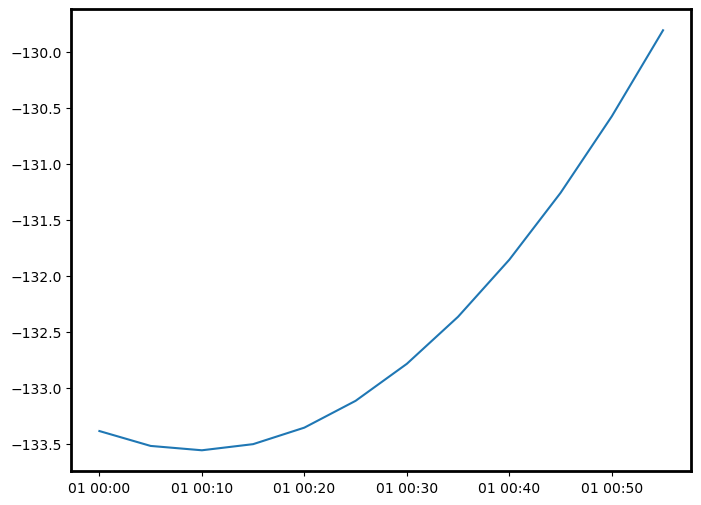

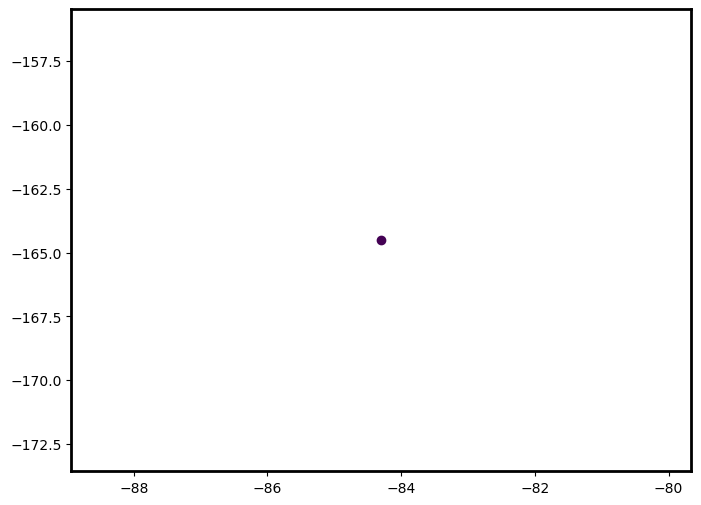

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(full_model.coords["t"], full_model.data)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
lats = [
    full_model.coords["lat_lon"].data[i].lat
    for i in range(len(full_model.coords["lat_lon"].data))
]
lons = [
    full_model.coords["lat_lon"].data[i].lon
    for i in range(len(full_model.coords["lat_lon"].data))
]
print(lats, lons)
print(full_model.sel(t="2010-01-01 00:00:00").data)
ax.scatter(lats, lons, c=full_model.sel(t="2010-01-01 00:00:00").data)

In [155]:
lon_lats = [(10, 11), (12, 13)]
lats = [-84.2986, -84.22, -84.10]
lons = [-164.5206, -163.60, -165.77]
datetimes = [1, 2]
tide = np.array([[1, 2], [4, 5], [7, 8]])

obj_arr = [LatLon(lat, lon) for lat, lon in zip(lats, lons)]
print(obj_arr[0].lat)
tides = xr.DataArray(
    dims=("lat_lon", "t"),
    coords={"t": datetimes, "lat_lon": obj_arr},
    data=tide,
    attrs=dict(
        description="Tide Height",
        units="cm",
    ),
)
print(tides)
print(tides["tide"].data)
print(tides["lat_lon"].data[0].lat)

-84.2986
<xarray.DataArray (lat_lon: 3, t: 2)> Size: 48B
array([[1, 2],
       [4, 5],
       [7, 8]])
Coordinates:
  * t        (t) int64 16B 1 2
  * lat_lon  (lat_lon) object 24B <__main__.LatLon object at 0x7fd6a5169510> ...
Attributes:
    description:  Tide Height
    units:        cm


KeyError: 'tide'

In [57]:
x = [
    (-0.09565199812411103 + 0.08094599504994772j),
    (-0.13586140480419281 - 0.049585767667016785j),
    (-0.08155616843858433 - 0.11338944374159984j),
    (-0.06223747508305972 - 0.005856088731639689j),
    (-0.4211198986023016 + 0.15126135999386958j),
    (-0.3585195741599564 + 0.024709306021179666j),
    (-0.1513224768995377 + 0.044382296294936695j),
    (-0.07789854098173525 - 0.008135609085355565j),
    (-0.02933214830192798 + 0.008847485156485922j),
    (-0.016474623542559238 + 0.0025423783053962518j),
]
y = [x]
print(y)
y = np.ma.array([x], dtype=np.complex128)
print(y.real[0, 2])

[[(-0.09565199812411103+0.08094599504994772j), (-0.13586140480419281-0.049585767667016785j), (-0.08155616843858433-0.11338944374159984j), (-0.06223747508305972-0.005856088731639689j), (-0.4211198986023016+0.15126135999386958j), (-0.3585195741599564+0.024709306021179666j), (-0.1513224768995377+0.044382296294936695j), (-0.07789854098173525-0.008135609085355565j), (-0.02933214830192798+0.008847485156485922j), (-0.016474623542559238+0.0025423783053962518j)]]
-0.08155616843858433
